In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
import numpy as np
import os
import io
import moonphase
import datetime
import imageio

In [2]:
date = "20230907"
hour = "00"
nlct_path = "/mnt/data2/jturner/nlct_data/gulf_stream/"+date+"/"

### Plot image

In [3]:
filename = 'goes_e_ntlc_'+date[0:4]+'_'+date[4:6]+'_'+date[6:8]+'_'+hour+'H_00M.nc'

BTD = xr.open_dataset(nlct_path+filename)

In [4]:
BTD_values = BTD.__xarray_dataarray_variable__[0]
BTD_values

<xarray.DataArray '__xarray_dataarray_variable__' (y: 471, x: 1167)>
[549657 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2023-09-07
    y_image  float32 ...
    x_image  float32 ...
  * y        (y) float64 0.1186 0.1186 0.1185 0.1185 ... 0.09243 0.09237 0.09232
  * x        (x) float64 -0.005012 -0.004956 -0.0049 ... 0.06017 0.06023 0.06028
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...

In [5]:
#---Northeast US
# min_lon = -83
# min_lat = 26
# max_lon = -51
# max_lat = 50

#---Chilean Coast
# min_lon = -95
# min_lat = -37
# max_lon = -65
# max_lat = -10

#--- Oaxaca
# min_lon = -109
# min_lat = 10
# max_lon = -81
# max_lat = 24

#---Georges Bank
# min_lon = -71.5
# min_lat = 37
# max_lon = -64
# max_lat = 42.5

#---Gulf Stream
# min_lon = -77
# min_lat = 33
# max_lon = -50
# max_lat = 45

#--Custom
min_lon = -76
min_lat = 36
max_lon = -61
max_lat = 45

In [6]:
BTD_masked = BTD_values.where(BTD_values >= 0, 0)

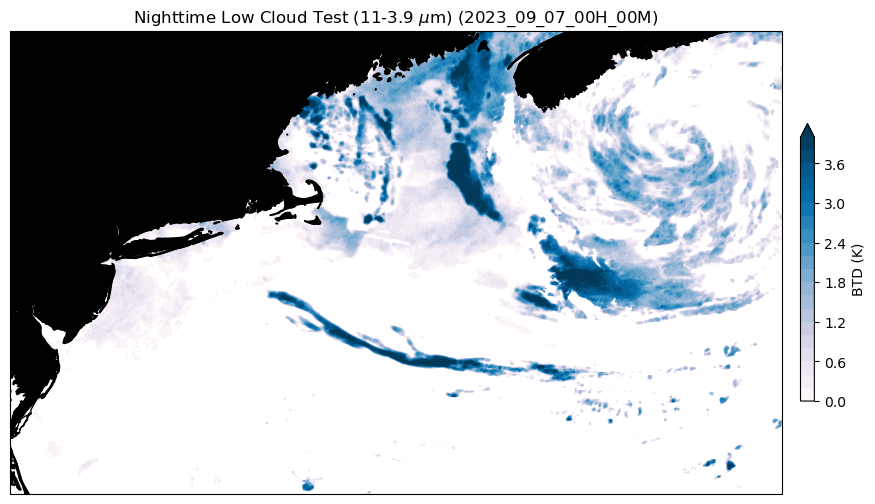

In [7]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.PuBu
levels = np.linspace(0, 4, 21)

ax.set_extent([min_lon, max_lon, min_lat, max_lat])
c=ax.contourf(BTD.lon, BTD.lat, BTD_values, cmap=cmap, extend='max', levels=levels)
#--- Black outline only
#c=ax.contour(BTD.lon, BTD.lat, BTD_values, colors='black', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Nighttime Low Cloud Test (11-3.9 $\mu$m) ('+filename[12:30]+')')
clb.set_label('BTD (K)')

ax.add_feature(cfeature.LAND, zorder=100, color='black', edgecolor='k')
ax.coastlines(resolution='50m', color='black', linewidth=1)
#plt.savefig('sample_images/nlct_'+date+'_'+hour+'.png', bbox_inches='tight')

Moon phase, using the code from moonphase.py:

In [ ]:
dt_var = datetime.datetime(int(date[:4]), int(date[4:6]), int(date[6:8]))

print("Position:", moonphase.position(dt_var))
print("Phase:", moonphase.phase(moonphase.position(dt_var)))

### Create Animation

In [ ]:
def create_frame(filename):
    
    #---Open Band 07 file
    file = open(nlct_path+filename, 'rb')
    BT = pickle.load(file)
    file.close()
    
    #---Crop image to the region of interest
    BT_c = BT.where((BT.lat>min_lat) & (BT.lat<max_lat) & (BT.lon>min_lon) & (BT.lon<max_lon))
    BT_c = BT_c.dropna(dim="y", how="all")
    BT_c = BT_c.dropna(dim="x", how="all")
    
    #---Set positive values to zero
    BTD_c = BT_c[0].where(BT_c[0] >= 0, 0)
    
    #---Create figure for timestamp
    projection=ccrs.PlateCarree()
    fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
    cmap = plt.cm.PuBu
    
    c=ax.contourf(BT_c.lon, BT_c.lat, BT_c[0], cmap=cmap, levels=levels)
    clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
    datetime = filename[12:]
    ax.set_title('ABI NLCT ('+datetime+')', fontsize=30)
    clb.set_label('BTD (K)')
    ax.add_feature(cfeature.STATES)

    # Save the current figure to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)


    # Read the BytesIO buffer and return as an image
    frame = imageio.imread(buf)

    # Clear the current figure to avoid overlapping plots
    plt.clf()

    return frame

In [ ]:
file_list = os.listdir(nlct_path)
file_list.sort()

anim_list = []

for filename in file_list:
    #---Add to only view 'top of the hour'
    #if filename.endswith("00M"):
    anim_list.append(filename)

In [ ]:
anim_list

In [ ]:
frames = []
for filename in anim_list:
    frame = create_frame(filename)
    frames.append(frame)

In [ ]:
duration = 500 #ms

imageio.mimsave('nlct_'+nlct_path[10:18]+'.gif', frames, loop=0, duration=duration)